In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import os
import warnings
import csv
import pprint
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import calendar
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import seaborn as sns
from matplotlib.pyplot import figure

In [10]:
#Loading files from google drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Unprocessed trade flow file
id = '1pUzUckRs5y1XU-TueOI2mcPinygGjMeN'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('tflows')

# Tflow_countries_region_match to create poten demand & supply centres
id = '12BCjLJckYRirOh0eT_--fhTZRNzWjtop'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('tflows_cntry_match')

# Historical Temperature All regions CSV file from google drive 
id = '1yS0N1hVeJEIKhAbuEzMPEwNjsQahOxax'
#id = '1mVTAqtD8jb9rPwNdB_bA-U7O993ebvYy'#previous file
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Hist_temp')

# Shipping rates file
id = '1rlY93U36q5xdEliN_Inp-uvCkjpbCvvb'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Ship_rate')

In [11]:
class Preprocess:
  def __init__(self):
    print("Preprocess object created")

  def countries(self, dat):
    '''List of countries in the trade-flow table with their corresponding poten regions'''
    dat['demand_centre'] = dat['demand_centre'].astype('bool')
    dat = dat.drop(['Region'], axis=1)
    return dat

  def trade_flows(self, dat, contries):
    ''' preprocess raw trade-flow data directly from the retures download, join with the countries table to get poten regions'''
    dat = dat.loc[dat['Status']=='Vessel Discharged', ('Load Countries/Regions', 'Discharge Countries/Regions', 'Arrival Date', 'Volume')]
    dat = dat.loc[dat["Arrival Date"].notna(),:]
    dat['month'], dat['year'], dat['week'] = dat['Arrival Date'].dt.month, dat['Arrival Date'].dt.year, dat['Arrival Date'].dt.isocalendar().week
    dat = dat.join(contries.loc[:,contries.columns != 'demand_centre'].set_index(['Country']), on=['Load Countries/Regions'], how='left', rsuffix='_load')
    dat = dat.join(contries.loc[:,contries.columns != 'demand_centre'].set_index(['Country']), on=['Discharge Countries/Regions'], how='left', rsuffix='_disch')
    dat = dat.rename(columns={"poten_region": "load_region", "poten_region_disch": "discharge_region"}, errors="raise")
    return dat

  def ind_regions(self, tflows, countries, exceptions):
    '''insert the independent countries as a list for exceptions as these countries are considered as there own regions '''
    for i in exceptions:
      if i not in list(countries['Country']):
        print(i, ' is not in countries list')
        raise TypeError()
        break
      else:
        tflows.loc[tflows['Load Countries/Regions']==i,'load_region'] = i
        tflows.loc[tflows['Discharge Countries/Regions']==i,'discharge_region'] = i
    return tflows
 
  def group_flows(self, cleaned_tflows, origin, dest, period):
    '''insert cleaned trade flows as per above to group them into weeks months years, period: 12 = monthly, 52 = weekly'''
    if period == 12: t = 'month'
    elif period == 52: t = "week"
    elif period == 26: t= 'fort_night'
    cleaned_tflows = cleaned_tflows.loc[((cleaned_tflows['load_region']==origin) & 
                                        (cleaned_tflows['discharge_region']==dest)),:]
    cleaned_tflows['fort_night'] = np.ceil(cleaned_tflows['week']/2)
    cleaned_tflows = cleaned_tflows.groupby(['load_region', 'year', t]).agg(
        vol = ('Volume', 'sum')
         ).reset_index()
    cleaned_tflows['year'], cleaned_tflows[t] = cleaned_tflows['year'].astype('int'), cleaned_tflows[t].astype('int')
    cleaned_tflows['Volume_MMt'] = cleaned_tflows['vol']*0.46*1e-6
    cleaned_tflows = cleaned_tflows.iloc[1:-1,:]
    return cleaned_tflows

  def process_temp(self, temp, country, period):
    ''' preprocessing for the Historical Temperature CSV file'''
    if period == 12: t = 'month'
    elif period == 52: t = "week"
    elif period == 26: t= 'fort_night'
    temp['Date time'] = pd.to_datetime(temp['Date time'])
    x = temp['City'].str.split(',', expand=True)
    temp['Country'], temp['City'] = x.loc[:,1].str.strip(), x.loc[:,0]
    temp.loc[temp['Country']=='Korea','Country'] = 'South Korea' # Changing name to match with tflows country name
    temp.loc[temp['Country']=='UK','Country'] = 'United Kingdom'
    temp['month'], temp['year'], temp['week'] = temp['Date time'].dt.month, temp['Date time'].dt.year, temp['Date time'].dt.isocalendar().week
    temp = temp.sort_values(by=['year', 'week'])
    temp = temp.loc[(temp['Country']==country) & (temp['year']> 2012),:]
    temp['fort_night'] = np.ceil(temp['week']/2)
    temp1 = temp.groupby(['year', t]).agg(
        Temp = ('Temperature', np.mean),
        Temp_sd = ('Temperature', np.std),
        Humidty = ('Relative Humidity', np.mean),
        Temp_max = ('Maximum Temperature', np.max),
        Temp_min = ('Minimum Temperature', np.min),
        No_days = ('Minimum Temperature', 'size')
        ).reset_index()
    temp2 = temp.groupby(['year', t])['Conditions'].apply(lambda x: (x=='Clear').sum()).reset_index(name='clear_count')
    joined = temp1.join(temp2.set_index(['year', t]), on=['year', t], how='left', rsuffix='_cond')
    joined['clear_days_prcnt'] = joined['clear_count']/joined['No_days']
    joined = joined.drop(['clear_count', 'No_days'], axis=1)
    joined = joined.iloc[:-1,:]
    joined = joined.dropna(how='all', axis=1) # some countries do not have the full complement of weather statistics
    joined = joined.loc[:, (joined != 0).any(axis=0)] # these two rows of code would delete columns if they are null or 0 
    return joined

  def process_ship_rate(self, ship_dat, period):
    '''insert raw ship rate data, period: 12 = monthly, 52 = weekly, 26 = fort_night'''
    if period == 12: t = 'month'
    elif period == 52: t = "week"
    elif period == 26: t= 'fort_night'
    ship_dat['avg_rate'] = ship_dat[['160M³ TFDE/DFDE (Cold) East', '160M³ TFDE/DFDE (Cold) West']].mean(axis=1)
    ship_dat['month'], ship_dat['year'], ship_dat['week'] = ship_dat['Date'].dt.month, ship_dat['Date'].dt.year, ship_dat['Date'].dt.isocalendar().week
    ship_dat['fort_night'] = np.ceil(ship_dat['week']/2)
    ship_dat = ship_dat.groupby(['year', t]).agg(
        ship_rate = ('avg_rate', np.mean),
        ship_rate_stdev = ('avg_rate', np.std),
        first = ('avg_rate', 'first'),
        last = ('avg_rate', 'last')
    ).reset_index()
    ship_dat['ship_rate_move'] = ship_dat['first'] - ship_dat['last']
    ship_dat.drop(['first', 'last'], axis=1, inplace=True)
    if t != 'month': ship_dat.drop(['ship_rate_stdev','ship_rate_move'], axis=1, inplace=True)
    ship_dat = ship_dat.iloc[:-1,:]
    return ship_dat

  def join_flows_temp(self, grouped_flows, grouped_temp, grouped_ship_rate, period):
    if period == 12: t = 'month'
    elif period == 52: t = "week"
    elif period == 26: t= 'fort_night'
    joined = grouped_flows.join(grouped_temp.set_index(['year', t]), on=['year', t], how='left', rsuffix='_temp')
    joined = joined.join(grouped_ship_rate.set_index(['year', t]), on =['year', t], how ='left', rsuffix='_ship_rate')
    joined = joined.drop(['load_region', 'vol'], axis=1)
    return joined


In [12]:
class Conduct_preprocess:
  def __init__(self):
    print("Creating Combined Dataframe")

  def create_combined_df(self, flows_df, temp_df, countries_df, ship_rate_df, ind_regions, origin, dest, period):
    '''Combine all preprocessing steps'''
    if period == 12: t = 'month'
    elif period == 52: t = "week"
    elif period == 26: t= 'fort_night'
    else:
      print(period, " is not a valid time input, insert 12 for monthly and 52 for weekly flows")
      raise TypeError()    
    p1 = Preprocess()
    cnt = p1.countries(countries_df)

    tflows = p1.ind_regions(
        tflows = p1.trade_flows(flows_df, cnt), 
        countries = cnt, 
        exceptions = ind_regions
        )
    
    grouped_flows = p1.group_flows(tflows, origin = origin, dest = dest, period=period)
    grouped_temp = p1.process_temp(temp_df, dest, period=period)
    grouped_ship_rate = p1.process_ship_rate(ship_rate_df, period)
    joined = p1.join_flows_temp(grouped_flows, grouped_temp, grouped_ship_rate, period=period)
    if t == 'week': joined = joined.loc[joined['week']!=53,:]
    elif t == 'fort_night': joined = joined.loc[joined['fort_night']!=27,:]
    print(t, "Trade flows:", origin," -> ", dest)
    return joined


In [13]:
cp = Conduct_preprocess()

tflows_df = pd.read_excel('tflows', sheet_name='Trade flows')
countries_df = pd.read_excel('tflows_cntry_match', sheet_name='Countries')
temperature_df = pd.read_csv('Hist_temp')
ship_rate_df = pd.read_excel("Ship_rate", sheet_name="Sheet1")

# specify period as 12 for monthly, 26 for fort_nightly and 52 for weekly data in period
ind_regions = ['Japan', 'South Korea', 'Taiwan', 'China']
origin = 'Australia & South East Asia'	
dest = 'Japan'
period = 12

combined_df = cp.create_combined_df(
    flows_df = tflows_df,
    temp_df = temperature_df,
    countries_df = countries_df,
    ship_rate_df = ship_rate_df,
    ind_regions = ind_regions,  
    origin = origin,
    dest = dest,
    period = period
)

combined_df.head()

Creating Combined Dataframe


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Preprocess object created
month Trade flows: Australia & South East Asia  ->  Japan


,year,month,Volume_MMt,Temp,Temp_sd,Humidty,Temp_max,Temp_min,clear_days_prcnt,ship_rate,ship_rate_stdev,ship_rate_move
1,2013,1,4.025089,5.519355,1.545622,47.696129,14.1,-2.9,0.838710,137.50,2.886751,5.0
2,2013,2,3.617763,6.135714,2.736477,47.811786,20.5,-0.4,0.642857,123.75,4.787136,10.0
3,2013,3,3.982800,12.090323,3.762477,54.659355,24.7,3.6,0.483871,108.00,7.582875,20.0
4,2013,4,3.073247,15.150000,3.421005,55.326333,23.1,5.7,0.566667,103.75,2.500000,-5.0
5,2013,5,2.887294,19.732258,2.632285,61.454516,27.8,10.6,0.548387,104.00,5.477226,10.0


In [112]:
from statsmodels.tsa.seasonal import seasonal_decompose
cp = Conduct_preprocess()

tflows = pd.read_excel('tflows', sheet_name='Trade flows')
countries = pd.read_excel('tflows_cntry_match', sheet_name='Countries')
temp = pd.read_csv('Hist_temp')

ind_regions = ['Japan', 'South Korea', 'Taiwan', 'China']
origin = 'Australia & South East Asia'	
dest = 'Taiwan'
period = 26

combined_df = cp.create_combined_df(
    flows_df = tflows,
    temp_df = temp,
    countries_df = countries,
    ind_regions = ind_regions,
    origin = origin,
    dest = dest,
    period = period,
    ship_rate_df = ship_rate_df
)

Creating Combined Dataframe


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Preprocess object created
fort_night Trade flows: Australia & South East Asia  ->  Taiwan


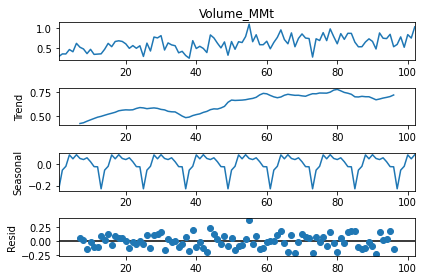

In [23]:
result = seasonal_decompose(combined_df['Volume_MMt'], model='additive', period=12)
result.plot()
plt.show()

In [113]:
n = 26
y_train, y_test, X_train, X_test = combined_df.iloc[:-n, 2], combined_df.iloc[len(combined_df)-n:, 2], combined_df.iloc[:-n,3:], combined_df.iloc[len(combined_df)-n:,3:]

#test, train = combined_df.iloc[:-n,:], combined_df.iloc[len(combined_df)-n:,:]

## **Japan Monthly**

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=135.788, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=152.270, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=150.007, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=130.136, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=150.284, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=136.613, Time=0.80 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=126.643, Time=0.75 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=128.689, Time=0.83 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=129.289, Time=0.82 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=126.307, Time=0.94 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=125.761, Time=0.98 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=121.823, Time=1.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=120.700, Time=0.89 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=121.382, Time=0.92 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=122.8

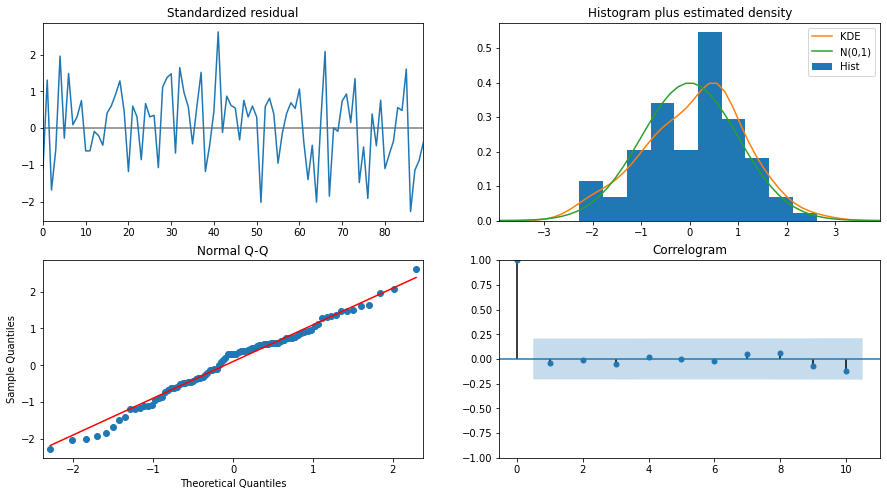

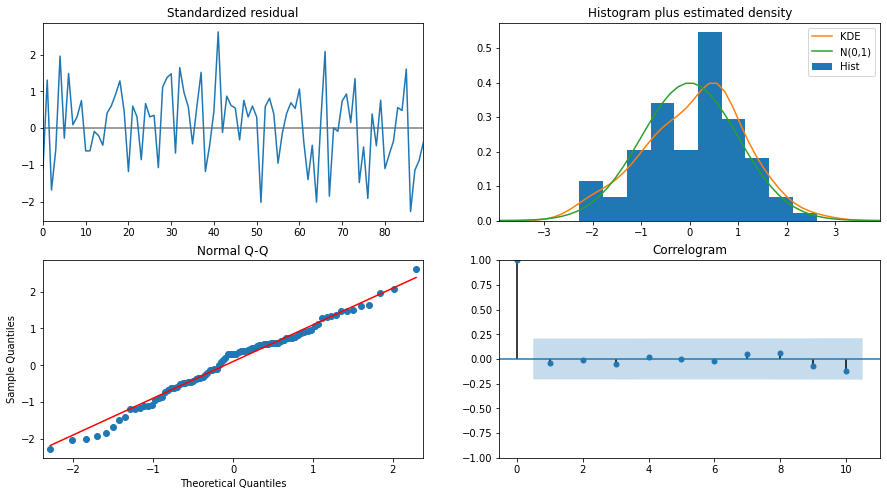

In [57]:
model = auto_arima(y_train, exogenous=X_train, trace=True, error_action="ignore", suppress_warnings=True)
model.fit(y_train, exogenous=X_train)

forecast = model.predict(n_periods=len(y_test), exogenous=X_test)
X_test["Forecast_ARIMAX"] = forecast
print(model.summary())
model.plot_diagnostics(figsize=(15, 8))

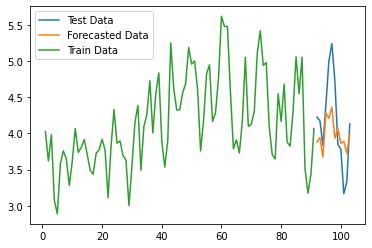

In [58]:
plt.plot(y_test)
plt.plot(X_test["Forecast_ARIMAX"])
plt.plot(y_train)
plt.legend(['Test Data','Forecasted Data', 'Train Data'])

In [59]:
print("MSE:", mean_squared_error(y_test, X_test["Forecast_ARIMAX"]))
print("RMSE:", np.sqrt(mean_squared_error(y_test, X_test["Forecast_ARIMAX"])))
print("MAE:", mean_absolute_error(y_test, X_test["Forecast_ARIMAX"]))
print("MAPE:", np.mean(np.abs((y_test - X_test["Forecast_ARIMAX"]) / y_test)) * 100,"%")

MSE: 0.25039947930547074
RMSE: 0.5003993198491289
MAE: 0.4079321323513964
MAPE: 9.697171635010372 %


## **Japan Fortnightly**

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=53.497, Time=1.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=118.963, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=79.046, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=56.046, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=116.965, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=57.174, Time=1.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=69.702, Time=1.00 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=58.123, Time=1.32 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=59.624, Time=1.34 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=62.078, Time=0.94 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=52.668, Time=1.36 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=51.845, Time=1.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=54.598, Time=1.01 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=47.307, Time=1.29 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=50.385, Time=1.43

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  199
Model:               SARIMAX(0, 1, 4)   Log Likelihood                 -10.953
Date:                Tue, 09 Nov 2021   AIC                             45.907
Time:                        19:32:25   BIC                             85.366
Sample:                             0   HQIC                            61.878
                                - 199                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Temp                -0.0207      0.020     -1.014      0.311      -0.061       0.019
Temp_sd              0.0436      0.049      0.886      0.376      -0.053       0.140
Humidty             -0.0044 

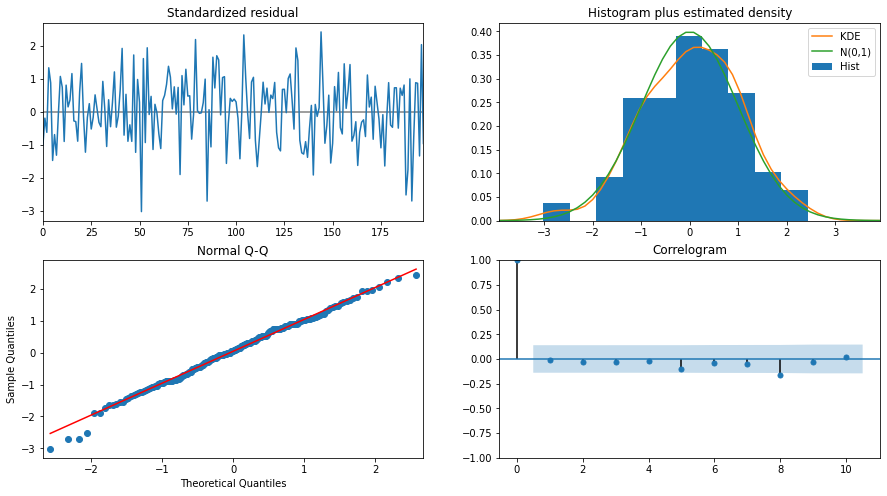

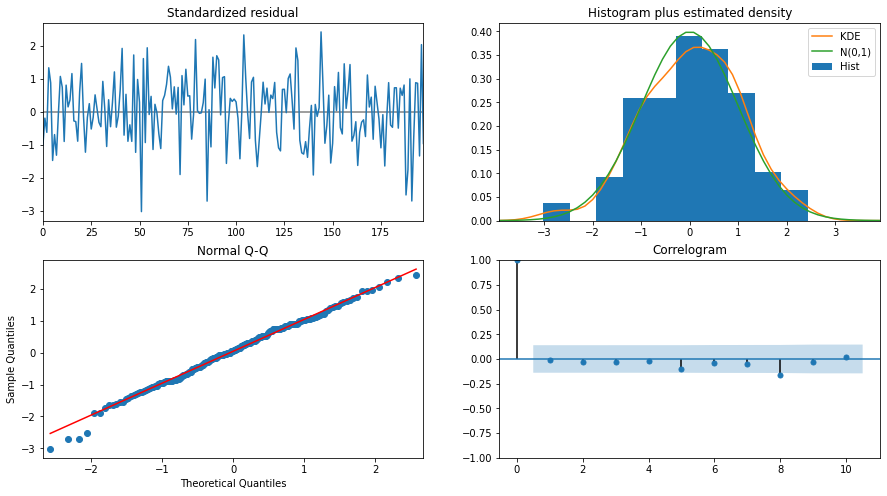

In [104]:
model = auto_arima(y_train, exogenous=X_train, trace=True, error_action="ignore", suppress_warnings=True)
model.fit(y_train, exogenous=X_train)

forecast = model.predict(n_periods=len(y_test), exogenous=X_test)
X_test["Forecast_ARIMAX"] = forecast
print(model.summary())
model.plot_diagnostics(figsize=(15, 8))

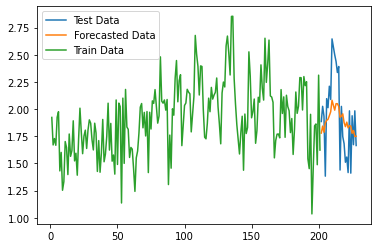

In [105]:
plt.plot(y_test)
plt.plot(X_test["Forecast_ARIMAX"])
plt.plot(y_train)
plt.legend(['Test Data','Forecasted Data', 'Train Data'])

In [106]:
print("MSE:", mean_squared_error(y_test, X_test["Forecast_ARIMAX"]))
print("RMSE:", np.sqrt(mean_squared_error(y_test, X_test["Forecast_ARIMAX"])))
print("MAE:", mean_absolute_error(y_test, X_test["Forecast_ARIMAX"]))
print("MAPE:", np.mean(np.abs((y_test - X_test["Forecast_ARIMAX"]) / y_test)) * 100,"%")

MSE: 0.09274757861165542
RMSE: 0.30454487126145374
MAE: 0.267702640628338
MAPE: 14.598556383939687 %


## **Japan Weekly**

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-134.993, Time=1.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=137.499, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-27.062, Time=0.85 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-139.383, Time=1.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=135.505, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-138.209, Time=1.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-137.813, Time=1.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-134.681, Time=1.64 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-140.931, Time=1.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-140.148, Time=1.32 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-139.775, Time=1.40 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-29.062, Time=0.73 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-137.007, Time=1.53 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 15.210 seconds


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  398
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  79.466
Date:                Tue, 09 Nov 2021   AIC                           -140.931
Time:                        19:21:12   BIC                           -105.076
Sample:                             0   HQIC                          -126.728
                                - 398                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Temp                -0.0197      0.013     -1.529      0.126      -0.045       0.006
Temp_sd              0.0297      0.024      1.215      0.224      -0.018       0.078
Humidty             -0.0039 

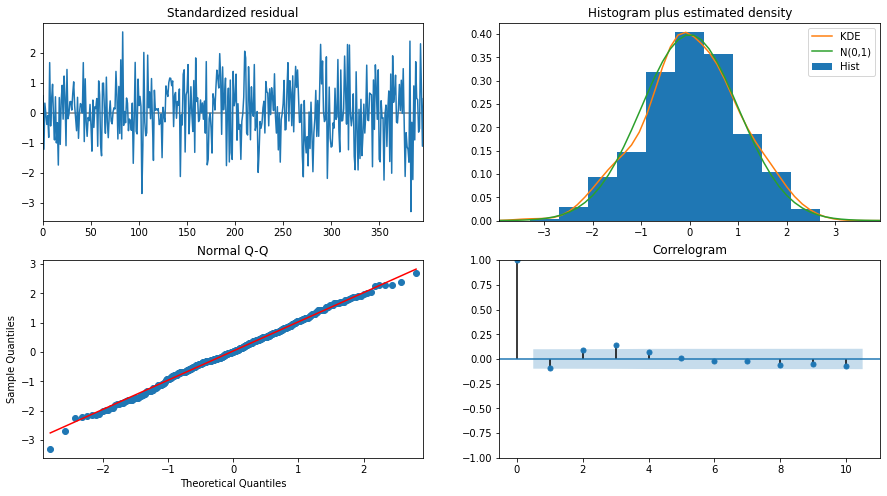

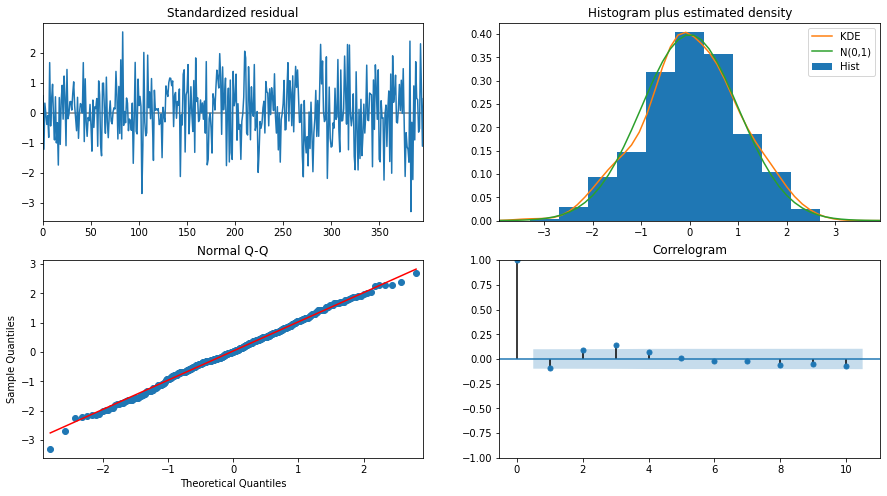

In [78]:
model = auto_arima(y_train, exogenous=X_train, trace=True, error_action="ignore", suppress_warnings=True)
model.fit(y_train, exogenous=X_train)

forecast = model.predict(n_periods=len(y_test), exogenous=X_test)
X_test["Forecast_ARIMAX"] = forecast
print(model.summary())
model.plot_diagnostics(figsize=(15, 8))

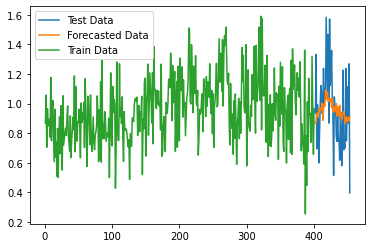

In [79]:
plt.plot(y_test)
plt.plot(X_test["Forecast_ARIMAX"])
plt.plot(y_train)
plt.legend(['Test Data','Forecasted Data', 'Train Data'])

In [80]:
print("MSE:", mean_squared_error(y_test, X_test["Forecast_ARIMAX"]))
print("RMSE:", np.sqrt(mean_squared_error(y_test, X_test["Forecast_ARIMAX"])))
print("MAE:", mean_absolute_error(y_test, X_test["Forecast_ARIMAX"]))
print("MAPE:", np.mean(np.abs((y_test - X_test["Forecast_ARIMAX"]) / y_test)) * 100,"%")

MSE: 0.05951706822094124
RMSE: 0.24396120228622672
MAE: 0.1874015319446411
MAPE: 21.887600562308393 %


## **China Monthly**

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=91.532, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=92.587, Time=0.42 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=84.518, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=91.412, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=84.197, Time=0.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=79.437, Time=0.84 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=86.621, Time=0.79 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=74.947, Time=1.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=75.111, Time=0.82 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=75.679, Time=0.96 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=72.565, Time=0.95 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=74.908, Time=1.08 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=70.649, Time=1.11 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=66.295, Time=1.05 sec


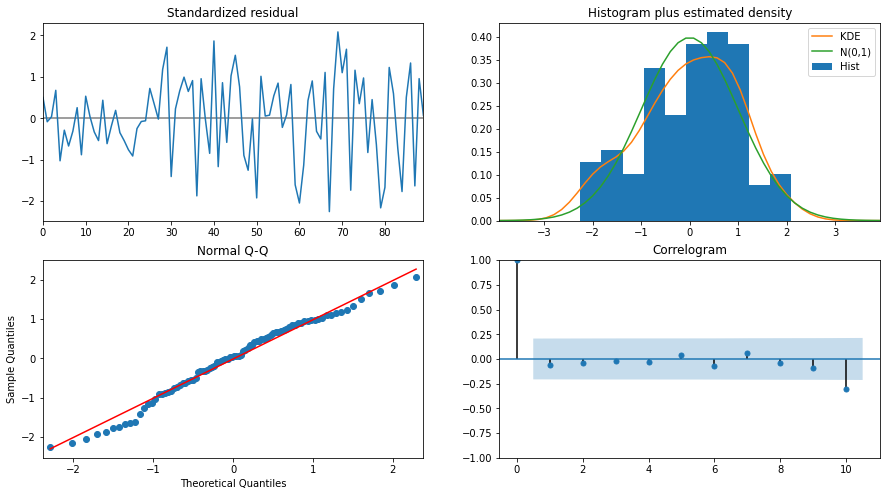

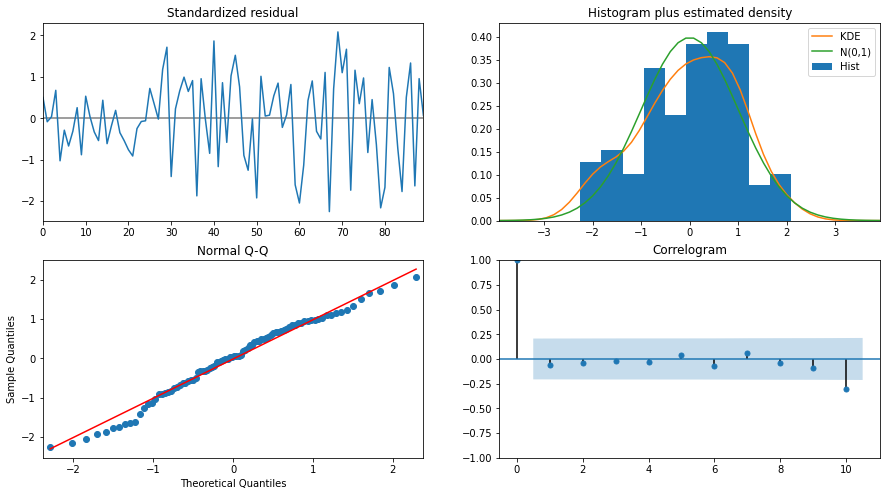

In [67]:
model = auto_arima(y_train, exogenous=X_train, trace=True, error_action="ignore", suppress_warnings=True)
model.fit(y_train, exogenous=X_train)

forecast = model.predict(n_periods=len(y_test), exogenous=X_test)
X_test["Forecast_ARIMAX"] = forecast
print(model.summary())
model.plot_diagnostics(figsize=(15, 8))

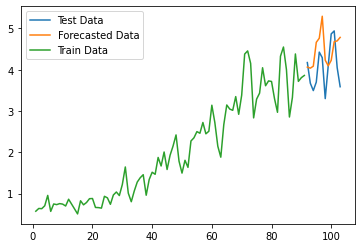

In [68]:
plt.plot(y_test)
plt.plot(X_test["Forecast_ARIMAX"])
plt.plot(y_train)
plt.legend(['Test Data','Forecasted Data', 'Train Data'])

In [69]:
print("MSE:", mean_squared_error(y_test, X_test["Forecast_ARIMAX"]))
print("RMSE:", np.sqrt(mean_squared_error(y_test, X_test["Forecast_ARIMAX"])))
print("MAE:", mean_absolute_error(y_test, X_test["Forecast_ARIMAX"]))
print("MAPE:", np.mean(np.abs((y_test - X_test["Forecast_ARIMAX"]) / y_test)) * 100,"%")

MSE: 0.47812788114268073
RMSE: 0.6914679176524973
MAE: 0.5871988559849126
MAPE: 15.208503440586844 %


## **China Fortnightly**

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-63.921, Time=1.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.640, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-55.268, Time=0.81 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-70.296, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.160, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-60.094, Time=0.97 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-68.793, Time=1.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-65.843, Time=1.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-61.440, Time=0.91 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 7.294 seconds


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  199
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  45.148
Date:                Tue, 09 Nov 2021   AIC                            -70.296
Time:                        19:34:19   BIC                            -37.413
Sample:                             0   HQIC                           -56.986
                                - 199                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept            0.0095      0.001     10.326      0.000       0.008       0.011
Temp                -0.0036      0.011     -0.314      0.754      -0.026       0.019
Temp_sd              0.0079 

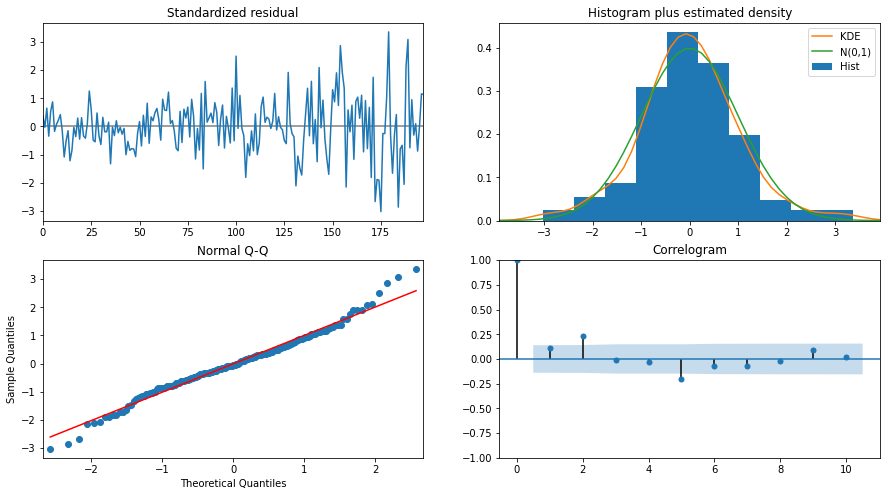

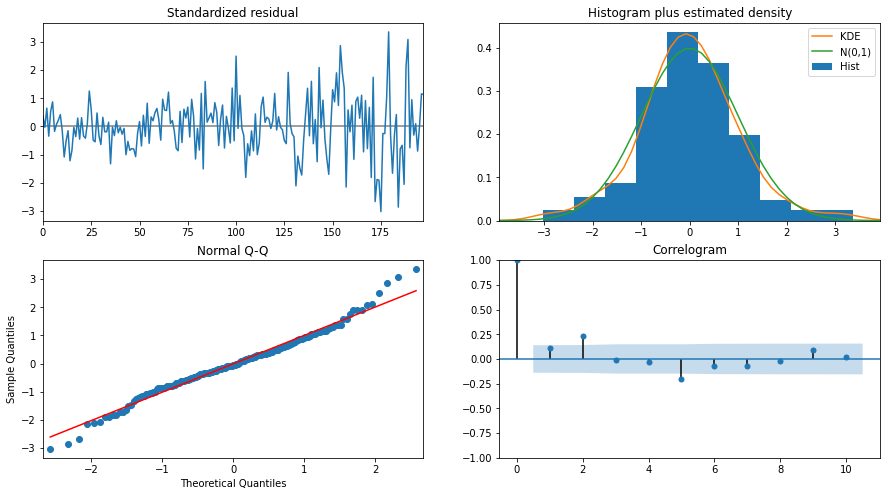

In [109]:
model = auto_arima(y_train, exogenous=X_train, trace=True, error_action="ignore", suppress_warnings=True)
model.fit(y_train, exogenous=X_train)

forecast = model.predict(n_periods=len(y_test), exogenous=X_test)
X_test["Forecast_ARIMAX"] = forecast
print(model.summary())
model.plot_diagnostics(figsize=(15, 8))

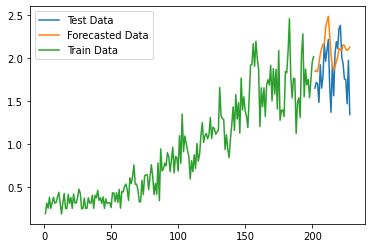

In [110]:
plt.plot(y_test)
plt.plot(X_test["Forecast_ARIMAX"])
plt.plot(y_train)
plt.legend(['Test Data','Forecasted Data', 'Train Data'])

In [111]:
print("MSE:", mean_squared_error(y_test, X_test["Forecast_ARIMAX"]))
print("RMSE:", np.sqrt(mean_squared_error(y_test, X_test["Forecast_ARIMAX"])))
print("MAE:", mean_absolute_error(y_test, X_test["Forecast_ARIMAX"]))
print("MAPE:", np.mean(np.abs((y_test - X_test["Forecast_ARIMAX"]) / y_test)) * 100,"%")

MSE: 0.12857007329772074
RMSE: 0.35856669295644394
MAE: 0.2964639353077738
MAPE: 17.661629933446804 %


## **China Weekly**

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-435.130, Time=1.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-202.316, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-330.594, Time=0.78 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-436.739, Time=1.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-204.214, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-438.121, Time=1.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-440.447, Time=1.60 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-380.383, Time=1.50 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-434.206, Time=1.83 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-437.033, Time=1.67 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-415.633, Time=1.67 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-432.502, Time=1.95 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-433.814, Time=1.95 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 18.112 seconds


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  398
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 232.223
Date:                Tue, 09 Nov 2021   AIC                           -440.447
Time:                        19:19:47   BIC                           -392.639
Sample:                             0   HQIC                          -421.509
                                - 398                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept            0.0025      0.001      2.912      0.004       0.001       0.004
Temp                -0.0043      0.006     -0.686      0.492      -0.017       0.008
Temp_sd             -0.0027 

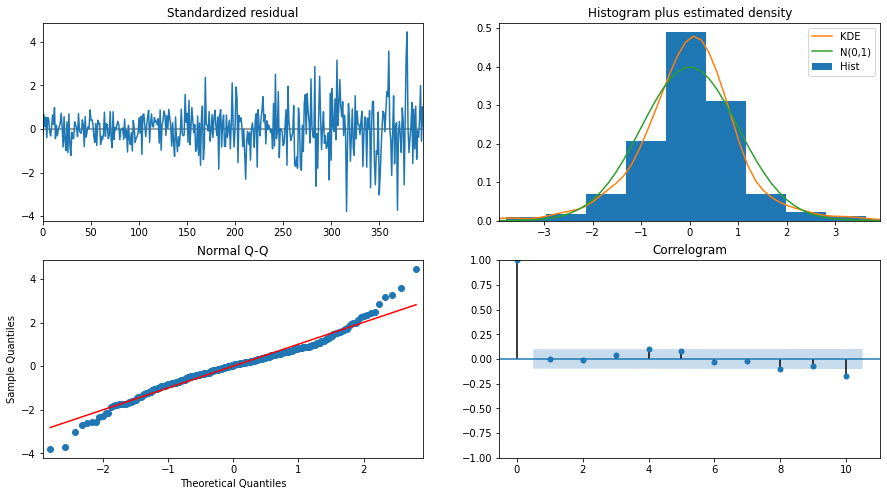

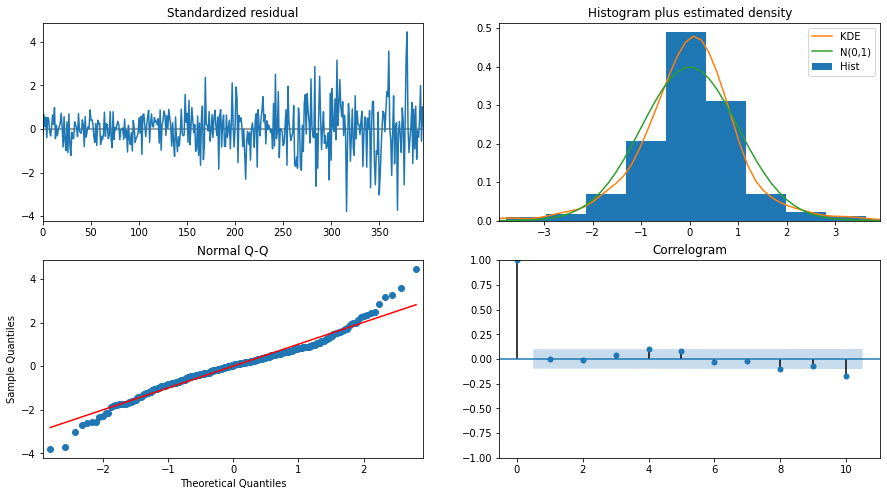

In [73]:
model = auto_arima(y_train, exogenous=X_train, trace=True, error_action="ignore", suppress_warnings=True)
model.fit(y_train, exogenous=X_train)

forecast = model.predict(n_periods=len(y_test), exogenous=X_test)
X_test["Forecast_ARIMAX"] = forecast
print(model.summary())
model.plot_diagnostics(figsize=(15, 8))

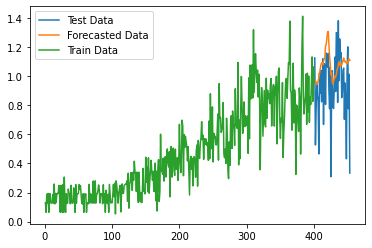

In [74]:
plt.plot(y_test)
plt.plot(X_test["Forecast_ARIMAX"])
plt.plot(y_train)
plt.legend(['Test Data','Forecasted Data', 'Train Data'])

In [75]:
print("MSE:", mean_squared_error(y_test, X_test["Forecast_ARIMAX"]))
print("RMSE:", np.sqrt(mean_squared_error(y_test, X_test["Forecast_ARIMAX"])))
print("MAE:", mean_absolute_error(y_test, X_test["Forecast_ARIMAX"]))
print("MAPE:", np.mean(np.abs((y_test - X_test["Forecast_ARIMAX"]) / y_test)) * 100,"%")

MSE: 0.07480669215295323
RMSE: 0.2735081208171948
MAE: 0.20926005117917545
MAPE: 32.22149902504337 %


## **South Korea Monthly**

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=26.524, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=55.290, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=45.698, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26.416, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=53.332, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26.412, Time=0.69 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=29.182, Time=0.77 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=24.102, Time=0.83 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=23.469, Time=0.75 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=24.501, Time=0.76 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=26.106, Time=0.88 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=25.327, Time=0.56 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 7.518 seconds
                               SARIMAX Results                                
Dep. Variable:                   

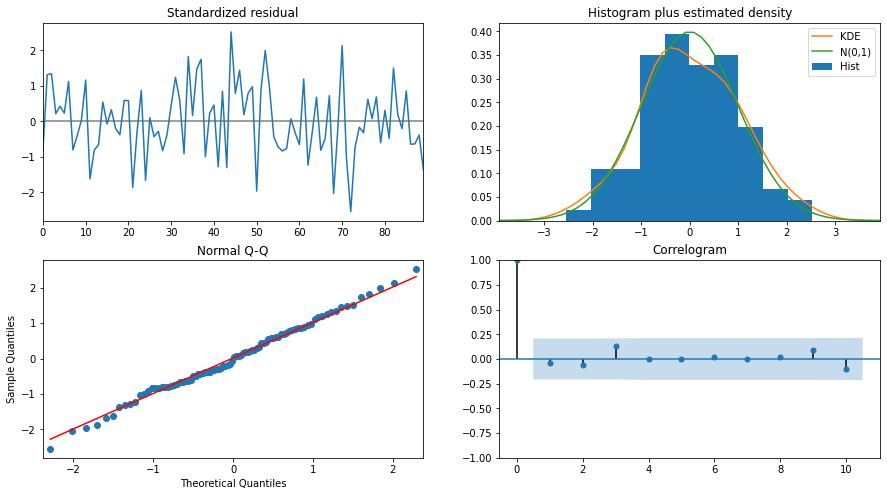

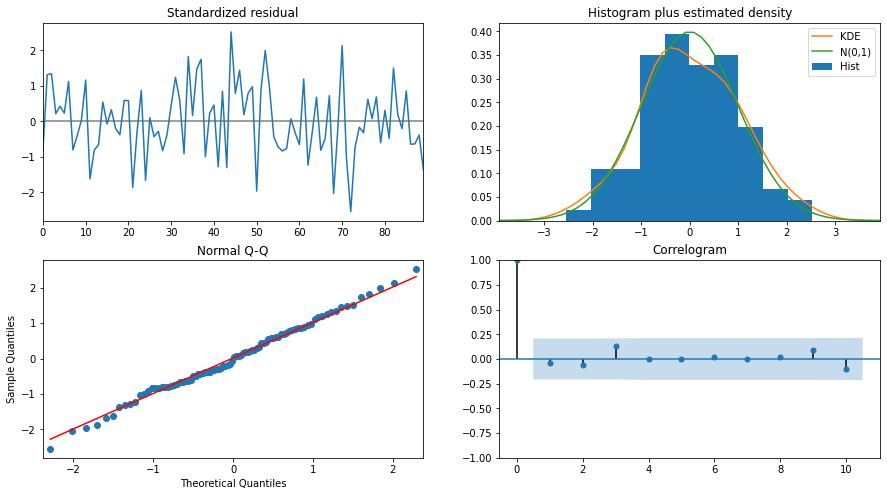

In [93]:
model = auto_arima(y_train, exogenous=X_train, trace=True, error_action="ignore", suppress_warnings=True)
model.fit(y_train, exogenous=X_train)

forecast = model.predict(n_periods=len(y_test), exogenous=X_test)
X_test["Forecast_ARIMAX"] = forecast
print(model.summary())
model.plot_diagnostics(figsize=(15, 8))

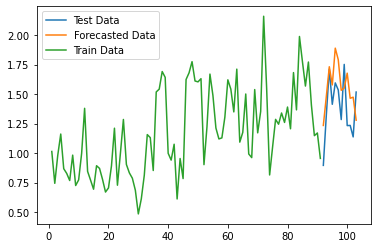

In [94]:
plt.plot(y_test)
plt.plot(X_test["Forecast_ARIMAX"])
plt.plot(y_train)
plt.legend(['Test Data','Forecasted Data', 'Train Data'])

In [95]:
print("MSE:", mean_squared_error(y_test, X_test["Forecast_ARIMAX"]))
print("RMSE:", np.sqrt(mean_squared_error(y_test, X_test["Forecast_ARIMAX"])))
print("MAE:", mean_absolute_error(y_test, X_test["Forecast_ARIMAX"]))
print("MAPE:", np.mean(np.abs((y_test - X_test["Forecast_ARIMAX"]) / y_test)) * 100,"%")

MSE: 0.0701576641617598
RMSE: 0.26487292077854957
MAE: 0.24420771894864748
MAPE: 19.043415123223987 %


## **South Korea Fortnightly**

In [101]:
model = auto_arima(y_train, exogenous=X_train, trace=True, error_action="ignore", suppress_warnings=True)
model.fit(y_train, exogenous=X_train)

forecast = model.predict(n_periods=len(y_test), exogenous=X_test)
X_test["Forecast_ARIMAX"] = forecast
print(model.summary())
model.plot_diagnostics(figsize=(15, 8))

ValueError: ignored

In [ ]:
plt.plot(y_test)
plt.plot(X_test["Forecast_ARIMAX"])
plt.plot(y_train)
plt.legend(['Test Data','Forecasted Data', 'Train Data'])

In [ ]:
print("MSE:", mean_squared_error(y_test, X_test["Forecast_ARIMAX"]))
print("RMSE:", np.sqrt(mean_squared_error(y_test, X_test["Forecast_ARIMAX"])))
print("MAE:", mean_absolute_error(y_test, X_test["Forecast_ARIMAX"]))
print("MAPE:", np.mean(np.abs((y_test - X_test["Forecast_ARIMAX"]) / y_test)) * 100,"%")

## **South Korea Weekly**

In [98]:
model = auto_arima(y_train, exogenous=X_train, trace=True, error_action="ignore", suppress_warnings=True)
model.fit(y_train, exogenous=X_train)

forecast = model.predict(n_periods=len(y_test), exogenous=X_test)
X_test["Forecast_ARIMAX"] = forecast
print(model.summary())
model.plot_diagnostics(figsize=(15, 8))

ValueError: ignored

In [ ]:
plt.plot(y_test)
plt.plot(X_test["Forecast_ARIMAX"])
plt.plot(y_train)
plt.legend(['Test Data','Forecasted Data', 'Train Data'])

In [ ]:
print("MSE:", mean_squared_error(y_test, X_test["Forecast_ARIMAX"]))
print("RMSE:", np.sqrt(mean_squared_error(y_test, X_test["Forecast_ARIMAX"])))
print("MAE:", mean_absolute_error(y_test, X_test["Forecast_ARIMAX"]))
print("MAPE:", np.mean(np.abs((y_test - X_test["Forecast_ARIMAX"]) / y_test)) * 100,"%")

## **Taiwan Monthly**

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-48.107, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-32.914, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-72.204, Time=0.42 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-81.167, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-34.886, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-80.977, Time=0.76 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-81.895, Time=0.80 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-75.395, Time=0.85 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-79.658, Time=0.89 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-83.083, Time=0.99 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-83.597, Time=1.01 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-81.211, Time=1.06 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-81.457, Time=1.10 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-81.015, Time=0.97 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-74.7

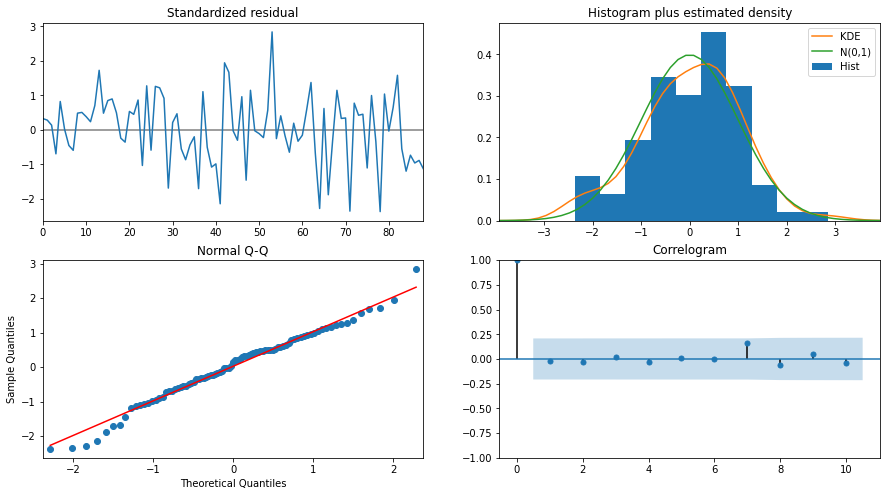

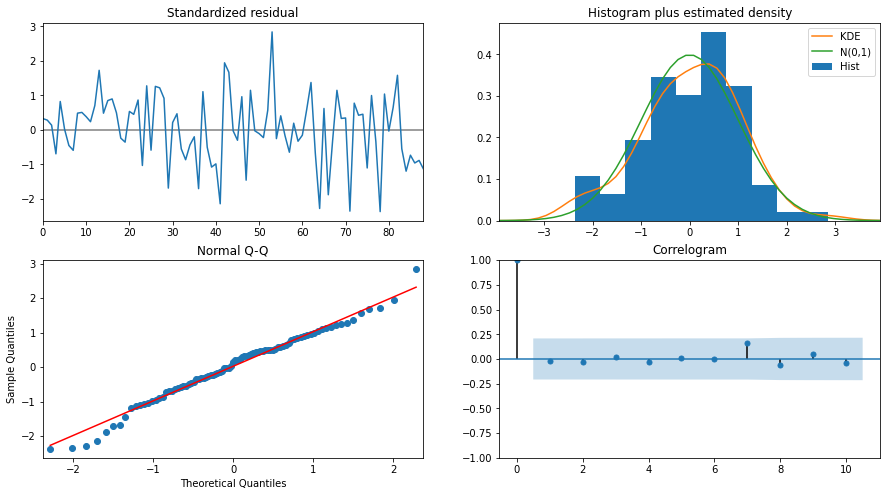

In [25]:
model = auto_arima(y_train, exogenous=X_train, trace=True, error_action="ignore", suppress_warnings=True)
model.fit(y_train, exogenous=X_train)

forecast = model.predict(n_periods=len(y_test), exogenous=X_test)
X_test["Forecast_ARIMAX"] = forecast
print(model.summary())
model.plot_diagnostics(figsize=(15, 8))

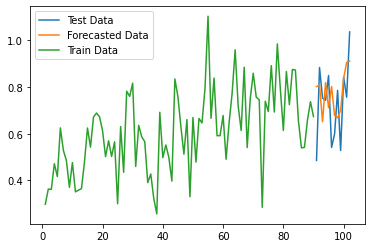

In [38]:
plt.plot(y_test)
plt.plot(X_test["Forecast_ARIMAX"])
plt.plot(y_train)
plt.legend(['Test Data','Forecasted Data', 'Train Data'])

In [48]:
print("MSE:", mean_squared_error(y_test, X_test["Forecast_ARIMAX"]))
print("RMSE:", np.sqrt(mean_squared_error(y_test, X_test["Forecast_ARIMAX"])))
print("MAE:", mean_absolute_error(y_test, X_test["Forecast_ARIMAX"]))
print("MAPE:", np.mean(np.abs((y_test - X_test["Forecast_ARIMAX"]) / y_test)) * 100,"%")

MSE: 0.02471810402142205
RMSE: 0.15721992246983857
MAE: 0.13463814893446563
MAPE: 21.24240218909469 %


## **Taiwan Fortnightly**

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-384.970, Time=1.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-230.068, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-334.607, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-381.927, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-232.017, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-384.191, Time=1.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-386.858, Time=1.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-383.356, Time=0.91 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-357.941, Time=1.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-379.705, Time=1.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-374.151, Time=0.98 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-375.949, Time=1.20 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-388.354, Time=0.94 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-385.437, Time=0.86 sec
 ARIMA(2,1,0)(0,0,0)[0]          

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  198
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 205.177
Date:                Tue, 09 Nov 2021   AIC                           -388.354
Time:                        19:36:53   BIC                           -352.239
Sample:                             0   HQIC                          -373.734
                                - 198                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Temp                 0.0109      0.009      1.234      0.217      -0.006       0.028
Temp_sd              0.0037      0.016      0.237      0.813      -0.027       0.035
Humidty           2.013e-05 

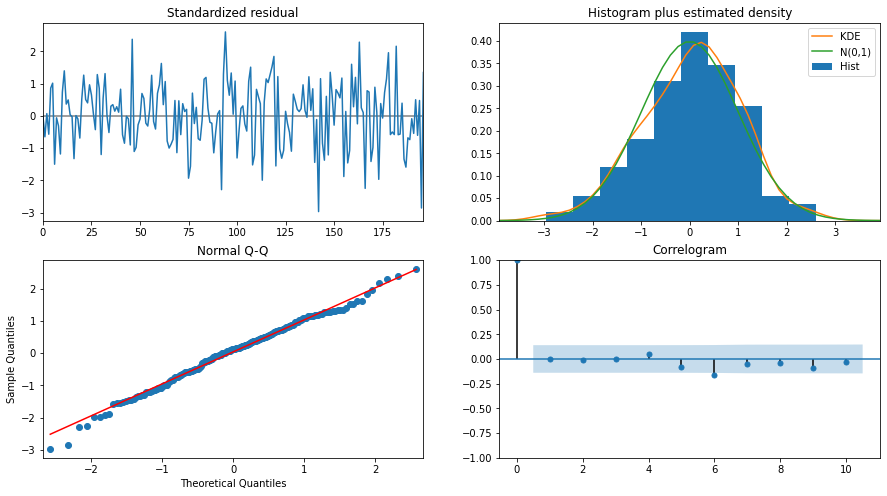

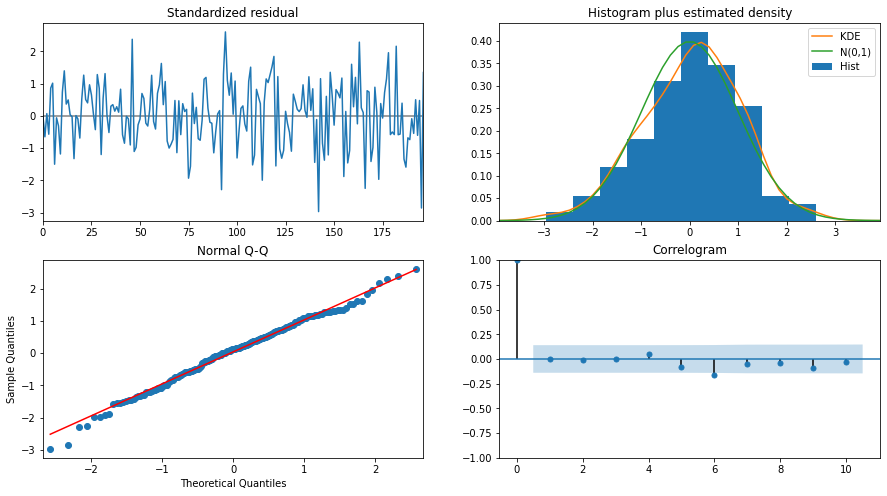

In [114]:
model = auto_arima(y_train, exogenous=X_train, trace=True, error_action="ignore", suppress_warnings=True)
model.fit(y_train, exogenous=X_train)

forecast = model.predict(n_periods=len(y_test), exogenous=X_test)
X_test["Forecast_ARIMAX"] = forecast
print(model.summary())
model.plot_diagnostics(figsize=(15, 8))

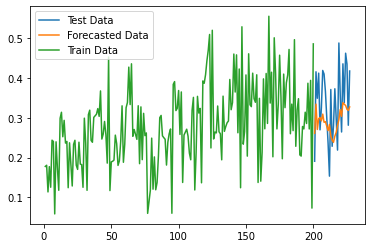

In [115]:
plt.plot(y_test)
plt.plot(X_test["Forecast_ARIMAX"])
plt.plot(y_train)
plt.legend(['Test Data','Forecasted Data', 'Train Data'])

In [116]:
print("MSE:", mean_squared_error(y_test, X_test["Forecast_ARIMAX"]))
print("RMSE:", np.sqrt(mean_squared_error(y_test, X_test["Forecast_ARIMAX"])))
print("MAE:", mean_absolute_error(y_test, X_test["Forecast_ARIMAX"]))
print("MAPE:", np.mean(np.abs((y_test - X_test["Forecast_ARIMAX"]) / y_test)) * 100,"%")

MSE: 0.007963924622536141
RMSE: 0.0892408237441595
MAE: 0.07725307647064773
MAPE: 23.290903834868296 %


## **Taiwan Weekly**

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1018.506, Time=1.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-743.361, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-877.608, Time=0.86 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1015.369, Time=1.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-745.338, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1012.527, Time=1.66 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1025.250, Time=1.68 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1013.245, Time=1.41 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-930.580, Time=1.46 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1006.574, Time=1.75 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-970.758, Time=1.72 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1011.403, Time=1.94 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1026.793, Time=1.37 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1015.054, Time=1.26 sec
 ARIMA(2,1,0)(0,0,0)[0] 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  384
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 524.396
Date:                Tue, 09 Nov 2021   AIC                          -1026.793
Time:                        19:23:28   BIC                           -983.365
Sample:                             0   HQIC                         -1009.566
                                - 384                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Temp                 0.0051      0.004      1.271      0.204      -0.003       0.013
Temp_sd             -0.0070      0.007     -0.935      0.350      -0.022       0.008
Humidty              0.0003 

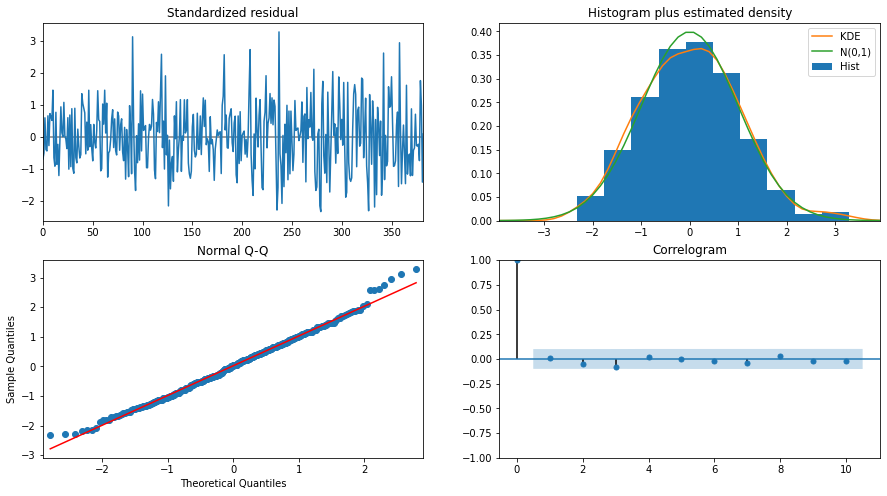

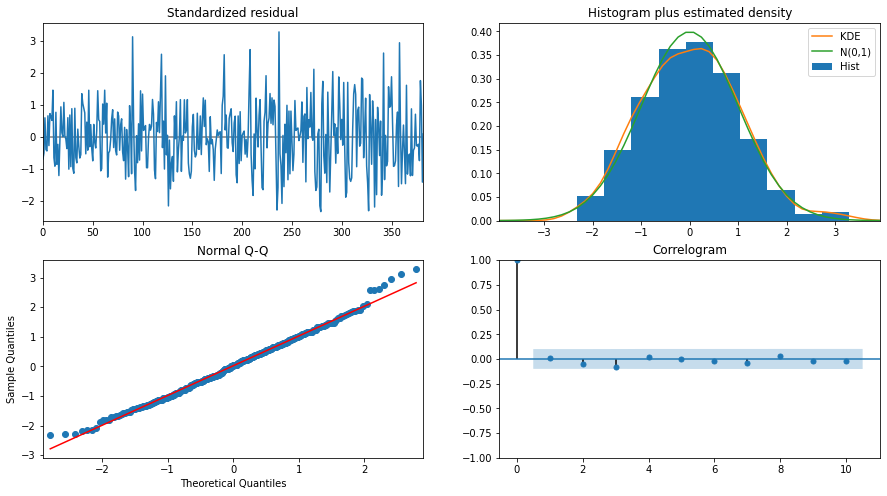

In [83]:
model = auto_arima(y_train, exogenous=X_train, trace=True, error_action="ignore", suppress_warnings=True)
model.fit(y_train, exogenous=X_train)

forecast = model.predict(n_periods=len(y_test), exogenous=X_test)
X_test["Forecast_ARIMAX"] = forecast
print(model.summary())
model.plot_diagnostics(figsize=(15, 8))

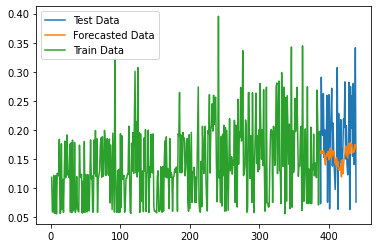

In [84]:
plt.plot(y_test)
plt.plot(X_test["Forecast_ARIMAX"])
plt.plot(y_train)
plt.legend(['Test Data','Forecasted Data', 'Train Data'])

In [85]:
print("MSE:", mean_squared_error(y_test, X_test["Forecast_ARIMAX"]))
print("RMSE:", np.sqrt(mean_squared_error(y_test, X_test["Forecast_ARIMAX"])))
print("MAE:", mean_absolute_error(y_test, X_test["Forecast_ARIMAX"]))
print("MAPE:", np.mean(np.abs((y_test - X_test["Forecast_ARIMAX"]) / y_test)) * 100,"%")

MSE: 0.005265482243827494
RMSE: 0.07256364271332783
MAE: 0.057831793906416844
MAPE: 35.80855984729355 %
